# Курсовой проект

1. [Импорт библиотек](#import)
2. [Загрузка данных](#load_data) <br>
    2.1. [Количественные переменные](#num_features) <br>
    2.2. [Номинативные переменные](#cat_features) <br>
3. [Предобработка данных](#preparation)
4. [Построение новых признаков](#new_features)
5. [Построение модели](#model)
6. [Сохранение результатов](#results)

**Задача** <br>
Предсказать стоимость покупок в датасете **test.csv** на основе обучающего датасета **train.csv**.

## Импорт библиотек <a class="anchor" id="import"></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import catboost as catb
import xgboost as xgb

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [1158]:
label_font = {
    "fontsize": 12,
    "family": "serif",
    "fontweight":"bold"
}

In [1159]:
import warnings
warnings.simplefilter('ignore')

## Загрузка данных <a class="anchor" id="load_data"></a>

In [1160]:
TEST_PATH = 'test.csv'
TRAIN_PATH = 'train.csv'

df = pd.read_csv(TRAIN_PATH)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1004085,P00075742,F,26-35,6,A,1,0,8,14.0,NaN,7803
1,1005491,P00234842,M,18-25,7,A,1,0,5,6.0,16.0,6903
2,1003499,P00220142,M,26-35,3,A,2,0,1,15.0,NaN,15773
3,1000097,P00211242,F,36-45,3,C,3,0,8,12.0,NaN,8116
4,1005802,P00327142,F,26-35,0,A,4+,0,8,15.0,NaN,6144



**Целевая переменная** <br>
   - Purchase - сумма покупок индивида

**Признаки** <br>

   - User_ID - идентификационный номер покупателя
   - Product_ID - идентификационный номер товара
   - Age - возраст покупателя
   - Occupation - род деятельности покупателя
   - City_Category - город проживания
   - Stay_In_Current_City_Years - как долго покупатель живет в этом городе
   - Marital_Status - семейное положение покупателя
   - Product_Category_1 - категория товара 1
   - Product_Category_2 - категория товара 2
   - Product_Category_3 - категория товара 3

In [1161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     80000 non-null  int64  
 1   Product_ID                  80000 non-null  object 
 2   Gender                      80000 non-null  object 
 3   Age                         80000 non-null  object 
 4   Occupation                  80000 non-null  int64  
 5   City_Category               80000 non-null  object 
 6   Stay_In_Current_City_Years  80000 non-null  object 
 7   Marital_Status              80000 non-null  int64  
 8   Product_Category_1          80000 non-null  int64  
 9   Product_Category_2          54892 non-null  float64
 10  Product_Category_3          24331 non-null  float64
 11  Purchase                    80000 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 7.3+ MB


Для признаков **Product_Category_2** и **Product_Category_3** присутствуют пропущенные значения. Необходимо проанализировать пропуски и определить использовать ли данные признаки в анализе. В случае положительного ответа нужно разработать механизм заполнения пропусков.

Проведем первичный анализ данных. Это позволит лучше понять их структуру и потенциально выявить зависимости, которые можно будет использовать.

### Целевая переменная

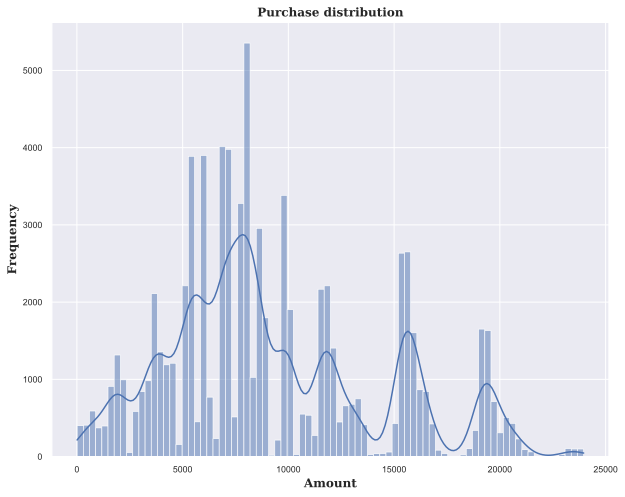

In [1162]:
plt.figure(figsize=(10,8))
sns.set(font_scale=0.8, style='darkgrid')
sns.histplot(df['Purchase'], kde=True)
plt.title('Purchase distribution', fontdict=label_font)
plt.ylabel('Frequency', fontdict=label_font)
plt.xlabel('Amount', fontdict=label_font)
plt.show()

Распределение не похоже ни на одно из стандартных распределений. Сильно отличается от нормального распределения. Мода явно видна, однако присутствует много локальных пиков, что придает распределению зубчатый вид.

### Количественные переменные <a class="anchor" id="num_features"></a>

In [1163]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,8.000000e+04,80000.000000,80000.000000,80000.000000,54892.000000,24331.000000,80000.000000
mean,1.003023e+06,8.086863,0.409388,5.388463,9.851873,12.676421,9243.933162
std,1.728959e+03,6.536459,0.491724,3.922793,5.079163,4.109343,5021.298356
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001503e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5679.750000
50%,1.003067e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8039.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12046.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


###### User_ID

In [1164]:
df['User_ID'].value_counts()

1004277    144
1001680    141
1001181    133
1001150    127
1001088    124
          ... 
1005199      1
1002709      1
1004920      1
1005637      1
1002287      1
Name: User_ID, Length: 5763, dtype: int64

Идентификационный номер покупателя не является уникальным значением. Скорее всего он каким-то образом описывает определенные схожие группы индивидов. Рассмотрим это предположение на примере случайного значения идентификатора.

In [1165]:
df[df['User_ID'] == 1001088]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
2017,1001088,P00047942,F,0-17,10,A,3,0,5,13.0,NaN,5207
2082,1001088,P00208842,F,0-17,10,A,3,0,11,16.0,NaN,4640
3774,1001088,P0096742,F,0-17,10,A,3,0,2,4.0,12.0,9699
3860,1001088,P00111742,F,0-17,10,A,3,0,15,NaN,NaN,21126
4276,1001088,P00023042,F,0-17,10,A,3,0,5,14.0,NaN,5319
...,...,...,...,...,...,...,...,...,...,...,...,...
78067,1001088,P00274242,F,0-17,10,A,3,0,1,NaN,NaN,19347
78507,1001088,P00364842,F,0-17,10,A,3,0,5,16.0,NaN,7132
79178,1001088,P00350942,F,0-17,10,A,3,0,3,4.0,5.0,11047
79657,1001088,P00195042,F,0-17,10,A,3,0,6,8.0,14.0,8576


Однако, на мой взгляд, нельзя утверждать, что он заменяет остальные признаки, описывающие покупателя. Как видно ниже, не все индивиды со схожими характеристиками имеют одинаковый **User_ID**.

In [1166]:
condition = (df['Gender'] == 'F') & (df['Occupation'] == 10) & \
            (df['Age'] == '0-17') & (df['City_Category'] == 'A') & (df['Stay_In_Current_City_Years'] == '3')
df[condition & (df['User_ID'] != 1001088)]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
9644,1001348,P0097142,F,0-17,10,A,3,0,12,NaN,NaN,1762
16265,1001348,P00351342,F,0-17,10,A,3,0,1,2.0,16.0,7946
17470,1001348,P00282142,F,0-17,10,A,3,0,3,4.0,NaN,10719
28539,1001348,P00064042,F,0-17,10,A,3,0,3,4.0,12.0,10835
32098,1001348,P00084842,F,0-17,10,A,3,0,8,16.0,NaN,8057
33034,1001348,P00195742,F,0-17,10,A,3,0,3,4.0,NaN,13548
43831,1001348,P00005342,F,0-17,10,A,3,0,4,5.0,NaN,2832
50955,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
60542,1001348,P00003942,F,0-17,10,A,3,0,5,14.0,NaN,3573
61194,1001348,P00189842,F,0-17,10,A,3,0,3,4.0,5.0,10663


Можно утверждать, что несмотря на то, что данный признак выражен числом, он скорее имеет категориальную природу.

##### Occupation

In [1167]:
df['Occupation'].value_counts()

4     10443
0     10188
7      8474
1      6921
17     5815
20     4887
12     4559
14     4030
2      3849
16     3724
6      2902
3      2598
10     1876
5      1824
15     1712
11     1706
19     1258
13     1132
18     1011
9       857
8       234
Name: Occupation, dtype: int64

Видим, что данный признак также принимает довольно ограниченное количество дискретных значений, это также позволяет утверждать, что признак скорее является категорией нежели количественной переменной.

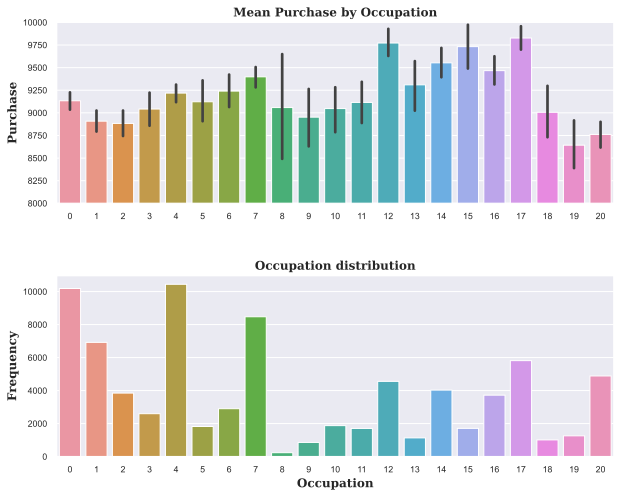

In [1168]:
fig, ax = plt.subplots(nrows=2, ncols=1)
ax1, ax2 = ax.flatten()

fig.set_size_inches(10, 8)
fig.subplots_adjust(wspace=0.4, hspace=0.4)
sns.set(font_scale=0.8, style='darkgrid')

sns.barplot(x='Occupation', y='Purchase', data=df, ax=ax1)
ax1.set_title('Mean Purchase by Occupation', fontdict=label_font)
ax1.set_ylabel('Purchase', fontdict=label_font)
ax1.set_xlabel('', fontdict=label_font)
ax1.set_ylim([8000, 10000])

sns.countplot(df['Occupation'])
ax2.set_title('Occupation distribution', fontdict=label_font)
ax2.set_ylabel('Frequency', fontdict=label_font)
ax2.set_xlabel('Occupation', fontdict=label_font)

plt.show()

Средние значения суммы покупок в зависимости от рода деятельности покупателя находятся в довольно узком диапазоне. Большинство доверительных интервалов пересекается.

Наибольшие средние значения суммы покупок наблюдаются для следующих значений **Occupation** - _12_, _14_ и _17_, которые встречаются довольно часто среди исследуемых покупателей, но не являются самыми популярными.

##### Marital_Status

In [1169]:
df['Marital_Status'].value_counts()

0    47249
1    32751
Name: Marital_Status, dtype: int64

Судя по всему данный бинарный признак просто показывает состоит ли покупатель в браке или нет.

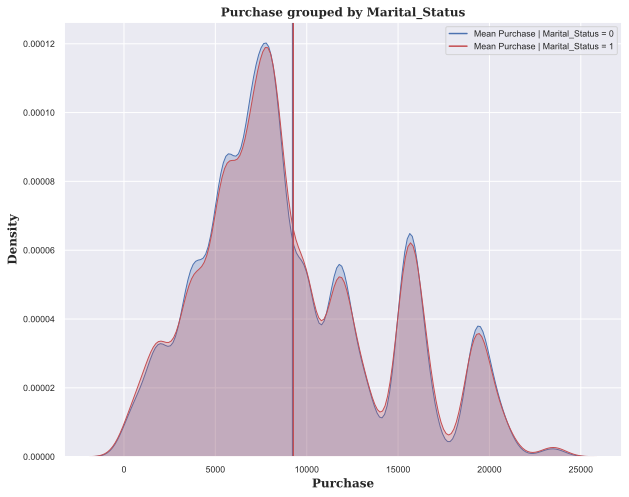

In [1170]:
plt.figure(figsize=(10,8))
sns.kdeplot(df.loc[df['Marital_Status'] == 0, 'Purchase'], shade=True)
plt.axvline(df.loc[df['Marital_Status'] == 0, 'Purchase'].mean(), color='b', 
            label='Mean Purchase | Marital_Status = 0')
sns.kdeplot(df.loc[df['Marital_Status'] == 1, 'Purchase'], shade=True, color='r')
plt.axvline(df.loc[df['Marital_Status'] == 1, 'Purchase'].mean(), color='r', 
            label='Mean Purchase | Marital_Status = 1')
plt.title('Purchase grouped by Marital_Status', fontdict=label_font)
plt.xlabel('Purchase', fontdict=label_font)
plt.ylabel('Density', fontdict=label_font)
plt.legend()
plt.show()

Судя по графику распределению данный признак оказывает минимальное влияние на сумму покупок покупателей.

##### Product_Category

In [1171]:
df['Product_Category_1'].value_counts()

5     22009
1     20446
8     16576
2      3487
11     3447
6      3015
3      2945
4      1719
16     1389
15      865
13      830
10      697
12      615
7       518
18      475
20      342
19      244
14      234
17       87
9        60
Name: Product_Category_1, dtype: int64

In [1172]:
df['Product_Category_2'].value_counts()

8.0     9351
14.0    8050
2.0     7062
16.0    6355
15.0    5487
5.0     3880
4.0     3823
6.0     2427
11.0    2077
17.0    1937
13.0    1535
12.0     799
9.0      784
10.0     460
18.0     400
3.0      378
7.0       87
Name: Product_Category_2, dtype: int64

In [1173]:
df['Product_Category_3'].value_counts()

16.0    4724
15.0    4084
14.0    2697
17.0    2425
5.0     2386
8.0     1805
9.0     1755
12.0    1403
13.0     794
6.0      725
18.0     689
11.0     257
4.0      253
10.0     241
3.0       93
Name: Product_Category_3, dtype: int64

Данные признаки изменяются в небольшом диапазоне и принимают дискретные значения. Судя по всему они каким-то образом описывают приобретенный товар/товары.

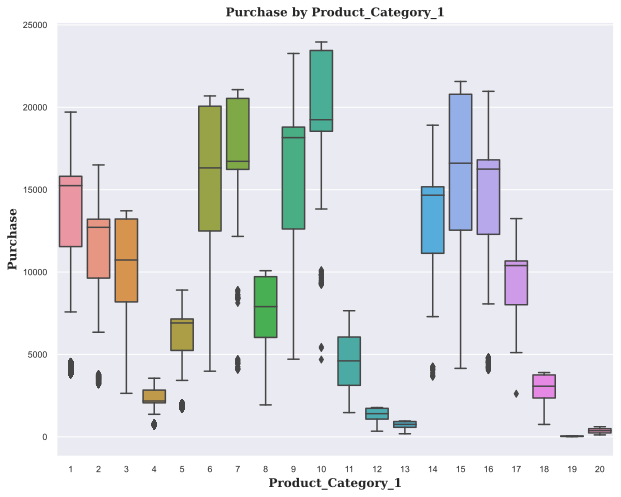

In [1174]:
plt.figure(figsize=(10,8))
sns.set(font_scale=0.8, style='darkgrid')
sns.boxplot(x='Product_Category_1', y='Purchase', data=df)
plt.title('Purchase by Product_Category_1', fontdict=label_font)
plt.ylabel('Purchase', fontdict=label_font)
plt.xlabel('Product_Category_1', fontdict=label_font)
plt.show()

Из данного графика видно, что этот признак может объяснять различия в сумме покупок. Значения целевой переменной для разных продуктовых категорий сильно различаются, особенно это заметно при сравнении ящиков с усами для категорий _10_ и _19_.

Теперь посмотрим на аналогичные графики для **Product_Category_2** и **Product_Category_3**.

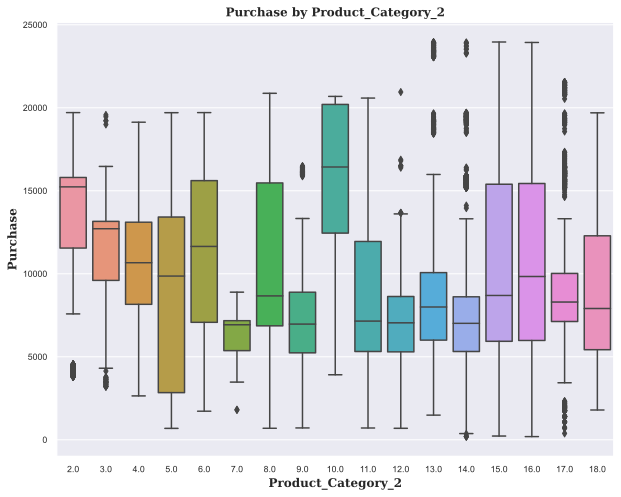

In [1175]:
plt.figure(figsize=(10,8))
sns.set(font_scale=0.8, style='darkgrid')
sns.boxplot(x='Product_Category_2', y='Purchase', data=df)
plt.title('Purchase by Product_Category_2', fontdict=label_font)
plt.ylabel('Purchase', fontdict=label_font)
plt.xlabel('Product_Category_2', fontdict=label_font)
plt.show()

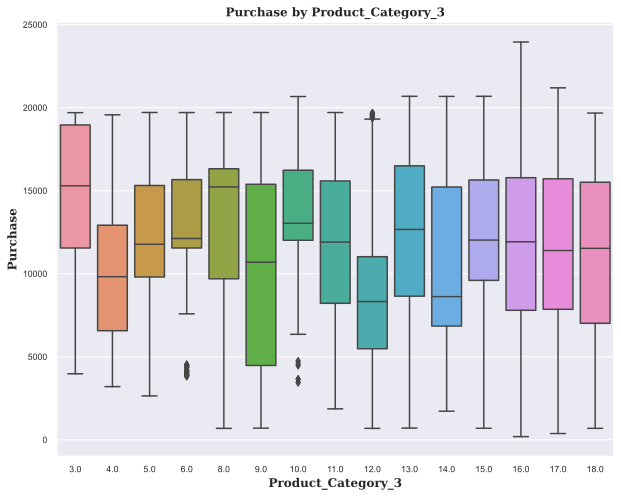

In [1176]:
plt.figure(figsize=(10,8))
sns.set(font_scale=0.8, style='darkgrid')
sns.boxplot(x='Product_Category_3', y='Purchase', data=df)
plt.title('Purchase by Product_Category_3', fontdict=label_font)
plt.ylabel('Purchase', fontdict=label_font)
plt.xlabel('Product_Category_3', fontdict=label_font)
plt.show()

Как видим для данных признаков наблюдается противоположная ситуация. Ожидать их большого вклада в объяснение изменчивости целевой переменной не приходится, особенно хорошо это видно на примере признака **Product_Category_3**.<br> Также можно обратить внимание, что диапазон принимаемых значений для этих переменных меньше:
- Product_Category_2 от _2_ до _18_ включительно;
- Product_Category_3 от _3_ до _18_ включительно.

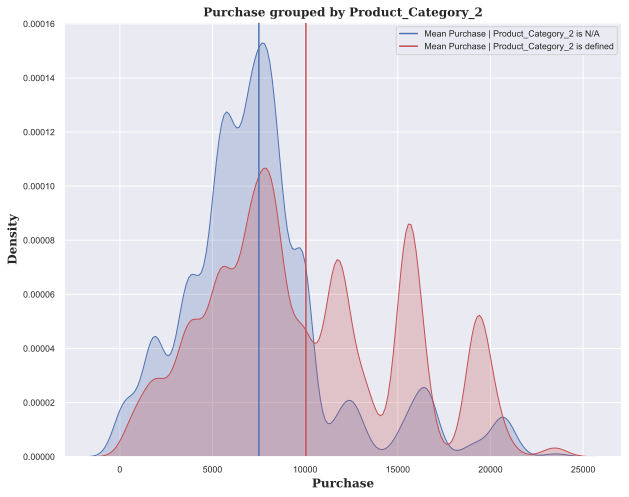

In [1177]:
plt.figure(figsize=(10,8))
sns.kdeplot(df.loc[df['Product_Category_2'].isna(), 'Purchase'], shade=True)
plt.axvline(df.loc[df['Product_Category_2'].isna(), 'Purchase'].mean(), color='b', 
            label='Mean Purchase | Product_Category_2 is N/A')
sns.kdeplot(df.loc[~df['Product_Category_2'].isna(), 'Purchase'], shade=True, color='r')
plt.axvline(df.loc[~df['Product_Category_2'].isna(), 'Purchase'].mean(), color='r', 
            label='Mean Purchase | Product_Category_2 is defined')
plt.title('Purchase grouped by Product_Category_2', fontdict=label_font)
plt.xlabel('Purchase', fontdict=label_font)
plt.ylabel('Density', fontdict=label_font)
plt.legend()
plt.show()

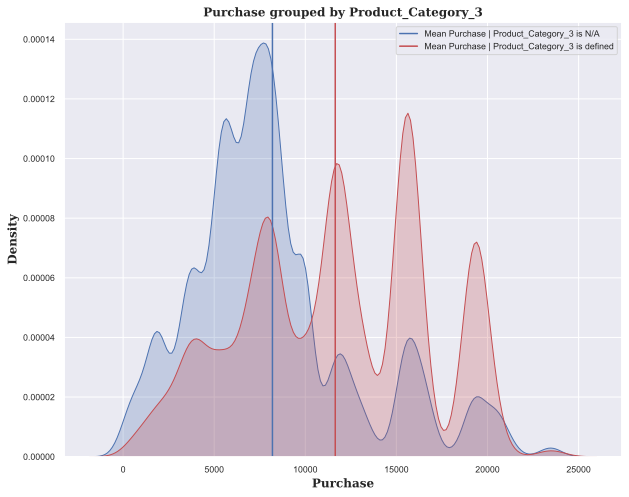

In [1178]:
plt.figure(figsize=(10,8))
sns.kdeplot(df.loc[df['Product_Category_3'].isna(), 'Purchase'], shade=True)
plt.axvline(df.loc[df['Product_Category_3'].isna(), 'Purchase'].mean(), color='b', 
            label='Mean Purchase | Product_Category_3 is N/A')
sns.kdeplot(df.loc[~df['Product_Category_3'].isna(), 'Purchase'], shade=True, color='r')
plt.axvline(df.loc[~df['Product_Category_3'].isna(), 'Purchase'].mean(), color='r', 
            label='Mean Purchase | Product_Category_3 is defined')
plt.title('Purchase grouped by Product_Category_3', fontdict=label_font)
plt.xlabel('Purchase', fontdict=label_font)
plt.ylabel('Density', fontdict=label_font)
plt.legend()
plt.show()

С другой стороны графики, приведенные выше, показывают, что сам факт наличия или отсутствия значения для **Product_Category_2** и **Product_Category_3** может быть очень полезен для предсказания суммы покупки. Особенно это заметно опять же для признака **Product_Category_3**, для которого распределения суммы покупок значительно отличаются.<br>
Поэтому, на мой взгляд, пропущенные значения имеет смысл заполнять каким-то значением, которое не встречается в признаке в нормальных условиях, например, _0_.

### Номинативные переменные <a class="anchor" id="cat_features"></a>

##### Product_ID

In [1179]:
df['Product_ID'].value_counts()

P00265242    272
P00025442    225
P00112142    224
P00058042    221
P00110742    220
            ... 
P00016242      1
P00022242      1
P00278342      1
P00240342      1
P00009642      1
Name: Product_ID, Length: 3256, dtype: int64

In [1180]:
df[df['Product_ID'] == 'P00110742'][['Product_Category_1', 'Product_Category_2', 'Product_Category_3']]

,Product_Category_1,Product_Category_2,Product_Category_3
15,1,2.0,8.0
212,1,2.0,8.0
358,1,2.0,8.0
365,1,2.0,8.0
549,1,2.0,8.0
...,...,...,...
78314,1,2.0,8.0
78482,1,2.0,8.0
79377,1,2.0,8.0
79397,1,2.0,8.0


В данном случае ситуация похожа на признак **User_ID**, так как этот идентификатор неким образом описывает товар, отчасти дублирую информацию содержающуся в категориях продукта.

In [1181]:
condition = (df['Product_Category_1']==1) & (df['Product_Category_2']==2) & (df['Product_Category_3']==8)
df.loc[condition, 'Product_ID'].value_counts()

P00110742    220
P00119642     73
P00222942     49
P00016342     35
P00223042     13
P00215242     12
P00217842     11
P00356342      1
Name: Product_ID, dtype: int64

##### Age

In [1182]:
df['Age'].value_counts()

26-35    32067
36-45    16025
18-25    14286
46-50     6777
51-55     5555
55+       3110
0-17      2180
Name: Age, dtype: int64

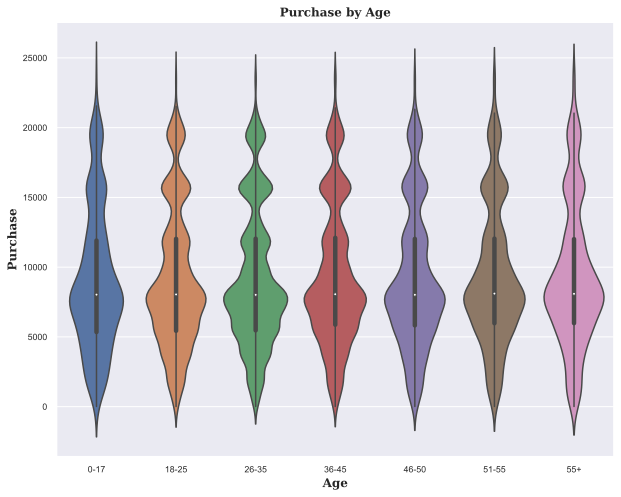

In [1183]:
plt.figure(figsize=(10,8))
sns.violinplot(x='Age', y='Purchase', data=df,
              order=['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'])
plt.title('Purchase by Age', fontdict=label_font)
plt.ylabel('Purchase', fontdict=label_font)
plt.xlabel('Age', fontdict=label_font)
plt.show()

Видим, что графики для различных возрастных групп очень похожи. Возможно только пики для групп "0-17" и "55+" в районе _15000_ менее выражены.

##### City_Category

In [1184]:
df['City_Category'].value_counts()

B    33767
C    24778
A    21455
Name: City_Category, dtype: int64

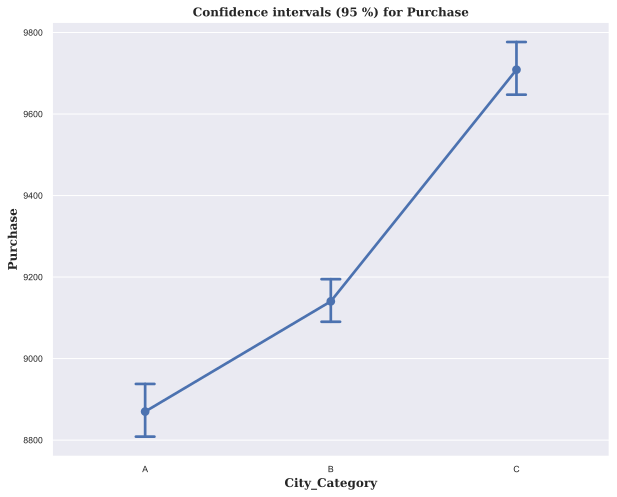

In [1185]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='City_Category', y='Purchase', data=df, capsize=.1, order=['A', 'B', 'C'])
plt.title('Confidence intervals (95 %) for Purchase', fontdict=label_font)
plt.ylabel('Purchase', fontdict=label_font)
plt.xlabel('City_Category', fontdict=label_font)
plt.show()

Можно ожидать, что как суммы покупок жителей разных городов будут отличаться.

##### Stay_In_Current_City_Years

In [1186]:
df['Stay_In_Current_City_Years'].value_counts()

1     28287
2     14830
3     13853
4+    12250
0     10780
Name: Stay_In_Current_City_Years, dtype: int64

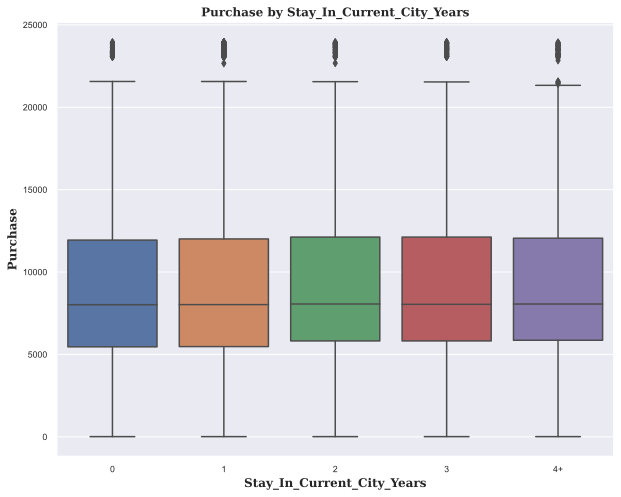

In [1187]:
plt.figure(figsize=(10,8))
sns.set(font_scale=0.8, style='darkgrid')
sns.boxplot(x='Stay_In_Current_City_Years', y='Purchase', data=df, order=['0', '1', '2', '3', '4+'])
plt.title('Purchase by Stay_In_Current_City_Years', fontdict=label_font)
plt.ylabel('Purchase', fontdict=label_font)
plt.xlabel('Stay_In_Current_City_Years', fontdict=label_font)
plt.show()

Различия между категориями минимальны, вряд ли можно ожидать серьезного влияния данного признака на сумму покупок.

##### Gender

In [1188]:
df['Gender'].value_counts()

M    60068
F    19932
Name: Gender, dtype: int64

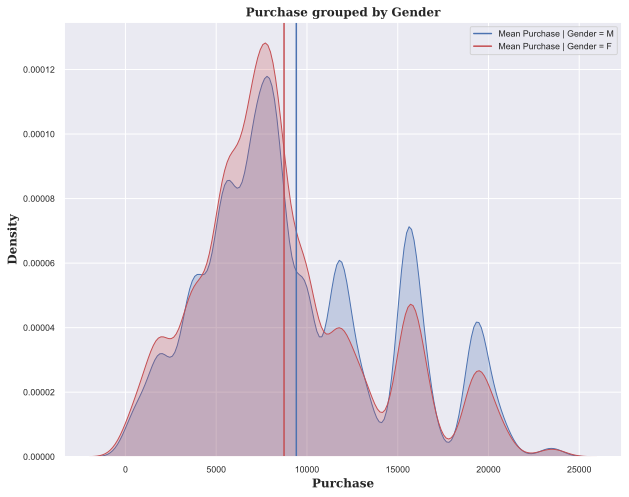

In [1189]:
plt.figure(figsize=(10,8))
sns.kdeplot(df.loc[df['Gender'] == 'M', 'Purchase'], shade=True)
plt.axvline(df.loc[df['Gender'] == 'M', 'Purchase'].mean(), color='b', 
            label='Mean Purchase | Gender = M')
sns.kdeplot(df.loc[df['Gender'] == 'F', 'Purchase'], shade=True, color='r')
plt.axvline(df.loc[df['Gender'] == 'F', 'Purchase'].mean(), color='r', 
            label='Mean Purchase | Gender = F')
plt.title('Purchase grouped by Gender', fontdict=label_font)
plt.xlabel('Purchase', fontdict=label_font)
plt.ylabel('Density', fontdict=label_font)
plt.legend()
plt.show()

Возможно пол покупателя играет роль при определении суммы покупок, однако важно учесть, что данные сильно несбалансированны по этому признаку.

## Предобработка данных <a class="anchor" id="preparation"></a>

Проблема выбросов в данном случае, на мой взгляд, не стоит, так как фактически все признаки являются в определенном смысле номинативными переменными.

Какую-то серьезную предобработку данных для этого случая проводить по моему мнению не требуется, достаточно заполнить пропуски в продуктовых категориях и убедиться, что нет других пропусков.

In [1190]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет мод, если будут пропуски в каких-то других признаках
        self.mode = X.mode()
    
    def transform(self, X):
        """Трансформация данных"""
        
        X['Product_Category_1'].fillna(0, inplace=True)
        X['Product_Category_2'].fillna(0, inplace=True)
        X['Product_Category_3'].fillna(0, inplace=True)
        
        
        X.fillna(self.mode, inplace=True)
        
        return X

## Построение новых признаков <a class="anchor" id="new_features"></a>

Добавим функцию для удобного отображения результатов модели.

In [1191]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))

Опишем построение новых признаков в отдельном классе, чтобы в дальнейшем было удобнее их генерировать для обучающей и тестовой выборок.

In [1192]:
class FeatureGenerator():
    
    def __init__(self):
        pass
    
    def fit(self, Z, y=None):
        X = Z.copy()
        
        # Частота, с которой встречается профессия
        self.occ_counts = X['Occupation'].value_counts()\
                            .reset_index().rename(columns={'index': 'Occupation', 'Occupation': 'Occupation_q'})
        
        # Частота, с которой встречается город
        self.city_counts = X['City_Category'].value_counts()\
                            .reset_index().rename(columns={'index': 'City_Category', 'City_Category': 'City_size'})

        # Частота, с которой встречается определенный продуктовый ID
        self.prod_counts = X['Product_ID'].value_counts().reset_index()\
                            .rename(columns={'index': 'Product_ID', 'Product_ID': 'Prod_q'})
        
        # Частота, с которой встречается профессия в каждом городе
        self.occ_city = X.groupby(['Occupation', 'City_Category'], as_index=False).agg({'User_ID':'count'})\
                                             .rename(columns={'User_ID':'Occ_City'})
        self.occ_city_median = self.occ_city['Occ_City'].median()
        
        # Частота, с которой встречается профессия для каждого срока проживания в городе
        self.occ_stay = X.groupby(['Occupation', 'Stay_In_Current_City_Years'], as_index=False).agg({'User_ID':'count'})\
                                             .rename(columns={'User_ID':'Occ_Stay'})
        self.occ_stay_median = self.occ_stay['Occ_Stay'].median()
        
        # Частота, с которой встречается определенный продуктовый ID в каждом городе
        self.prod_city = X.groupby(['Product_ID', 'City_Category'], as_index=False).agg({'User_ID':'count'})\
                                             .rename(columns={'User_ID':'Prod_City'})
        self.prod_city_median = self.prod_city['Prod_City'].median()
        

#         self.prod1_city = X.groupby(['Product_Category_1', 'City_Category'], as_index=False).agg({'User_ID':'count'})\
#                                              .rename(columns={'User_ID':'Prod_Cat1'})
#         self.prod1_city_median = self.prod1_city['Prod_Cat1'].median()
        
        # Частота, с которой встречается определенный продуктовый ID для каждой возрастной группы
        self.prod_age = X.groupby(['Product_ID', 'Age'], as_index=False).agg({'User_ID':'count'})\
                                             .rename(columns={'User_ID':'Prod_Age'})
        self.prod_age_median = self.prod_age['Prod_Age'].median()
        
        df = Z.copy()
        if y is not None:
            df['Purchase'] = y.values
            
            # Средняя величина покупок для профессии
            self.mean_purchase_by_occupation = df.groupby(['Occupation'], as_index=False).agg({'Purchase':'mean'})\
                                             .rename(columns={'Purchase':'MeanPurchaseByOccupation'})
            self.mean_purchase_by_occupation_median\
                                            = self.mean_purchase_by_occupation['MeanPurchaseByOccupation'].median()

            # Средняя величина покупок для возраста
            self.mean_purchase_by_age = df.groupby(['Age'], as_index=False).agg({'Purchase':'mean'})\
                                            .rename(columns={'Purchase':'MeanPurchaseByAge'})
            self.mean_purchase_by_age_median = self.mean_purchase_by_age['MeanPurchaseByAge'].median()
            
            # Средняя величина покупок для города
            self.mean_purchase_by_city = df.groupby(['City_Category'], as_index=False).agg({'Purchase':'mean'})\
                                            .rename(columns={'Purchase':'MeanPurchaseByCity'})
            self.mean_purchase_by_city_median = self.mean_purchase_by_city['MeanPurchaseByCity'].median()
            
            # Средняя величина покупок для пола
            self.mean_purchase_by_gender = df.groupby(['Gender'], as_index=False).agg({'Purchase':'mean'})\
                                            .rename(columns={'Purchase':'MeanPurchaseByGender'})
            self.mean_purchase_by_gender_median = self.mean_purchase_by_gender['MeanPurchaseByGender'].median()
            
        
        
    def transform(self, X):
        X = X.merge(self.occ_counts, on='Occupation', how='left')
        X = X.merge(self.city_counts, on='City_Category', how='left')
        X = X.merge(self.prod_counts, on='Product_ID', how='left')
        X = X.merge(self.occ_city, on=['Occupation', 'City_Category'], how='left')
        X.fillna(self.occ_city_median, inplace=True)
        X = X.merge(self.occ_stay, on=['Occupation', 'Stay_In_Current_City_Years'], how='left')
        X.fillna(self.occ_stay_median, inplace=True)
        X = X.merge(self.prod_city, on=['Product_ID', 'City_Category'], how='left')
        X.fillna(1, inplace=True)
        X = X.merge(self.prod_age, on=['Product_ID', 'Age'], how='left')
        X.fillna(1, inplace=True)
#         X = X.merge(self.prod1_city, on=['Product_Category_1', 'City_Category'], how='left')
#         X.fillna(self.prod1_city['Prod_Cat1'].median(), inplace=True)
        X['Prod_q'].fillna(1, inplace=True)
        X = X.merge(self.mean_purchase_by_gender, on='Gender', how='left')
        X.fillna(self.mean_purchase_by_gender_median, inplace=True) 
        X = X.merge(self.mean_purchase_by_city, on='City_Category', how='left')
        X.fillna(self.mean_purchase_by_city_median, inplace=True) 
        X = X.merge(self.mean_purchase_by_occupation, on='Occupation', how='left')
        X.fillna(self.mean_purchase_by_occupation_median, inplace=True)
        X = X.merge(self.mean_purchase_by_age, on='Age', how='left')
        X.fillna(self.mean_purchase_by_age_median, inplace=True)
        X['Product_Category_2'] = X['Product_Category_2'].astype('int')
        X['Product_Category_2'] = X['Product_Category_2'].astype('str')
        X['Product_Category_3'] = X['Product_Category_3'].astype('int')
        X['Product_Category_3'] = X['Product_Category_3'].astype('str')

        return X

## Построение модели <a class="anchor" id="model"></a>

In [1193]:
y = df['Purchase']
X = df.drop(columns=['Purchase'])

In [1194]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0)

In [1195]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [1196]:
features = FeatureGenerator()
features.fit(X_train, y_train)
X_train = features.transform(X_train)
X_valid = features.transform(X_valid)

In [1197]:
X_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Occupation_q', 'City_size',
       'Prod_q', 'Occ_City', 'Occ_Stay', 'Prod_City', 'Prod_Age',
       'MeanPurchaseByGender', 'MeanPurchaseByCity',
       'MeanPurchaseByOccupation', 'MeanPurchaseByAge'],
      dtype='object')

In [1198]:
X_train.drop(columns=['Marital_Status', 'Stay_In_Current_City_Years', 'City_size'], inplace=True)
X_valid.drop(columns=['Marital_Status', 'Stay_In_Current_City_Years', 'City_size'], inplace=True)

In [1199]:
final_model = catb.CatBoostRegressor(n_estimators=1000, max_depth=6,
                                     l2_leaf_reg=4, learning_rate=0.02,
                                     silent=True, random_state=0, 
                                     cat_features=['Product_ID', 'User_ID', 'City_Category',
                                                   'Gendeggr', 'Age', 'Product_Category_2', 'Product_Category_3'])

In [1200]:
final_model.fit(X_train, y_train)

In [1201]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_valid)

In [1202]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.745
Test R2:	0.717


In [1203]:
fi = pd.DataFrame(final_model.feature_importances_, index=X_train.columns, columns=['importance'])
fi.sort_values(by='importance', ascending=False)

,importance
Product_Category_1,44.871149
Product_ID,40.667764
User_ID,3.745872
Prod_q,3.268334
Product_Category_2,2.296100
Product_Category_3,1.641663
Prod_City,0.933025
City_Category,0.385655
Age,0.348176
MeanPurchaseByOccupation,0.315141


## Сохранение результатов <a class="anchor" id="results"></a>

In [1204]:
test_df = pd.read_csv('test.csv')
test_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1002118,P00108542,M,26-35,14,A,1,1,5,8.0,14.0
1,1002476,P00086442,M,51-55,12,C,1,1,8,13.0,15.0
2,1005220,P00248442,M,26-35,7,B,4+,0,3,4.0,NaN
3,1005213,P00270242,M,18-25,0,C,2,0,8,NaN,NaN
4,1002374,P00106042,M,26-35,14,B,2,0,5,NaN,NaN


In [1205]:
test_df = preprocessor.transform(test_df)

In [1206]:
test_df = features.transform(test_df)

In [1207]:
test_df.drop(columns=['Marital_Status', 'Stay_In_Current_City_Years', 'City_size'], inplace=True)

In [1208]:
y_test = final_model.predict(test_df)

In [1209]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Purchase
0,0,9000
1,1,9000
2,2,9000
3,3,9000
4,4,9000


In [1210]:
submit['Purchase'] = y_test

In [1211]:
submit.to_csv('cb_model_2.csv', index=False)